In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.stats as pearsonr
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.metrics import pairwise_distances_argmin_min
from statsmodels.graphics.gofplots import ProbPlot
#import warnings; warnings.simplefilter('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Importation du fichier source
data = pd.read_csv(r"C:\Users\elodi\Downloads\data-projet7.csv")

### Mission 1
Résumez les données utilisées :

- année(s) des données utilisées ;
- nombre de pays présents ;
- population couverte par l'analyse (en termes de pourcentage de la population mondiale).

Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective.
- De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
- Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

In [3]:
data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       11599 non-null  object
 1   year_survey   11599 non-null  int64 
 2   quantile      11599 non-null  int64 
 3   nb_quantiles  11599 non-null  int64 
 4   income        11599 non-null  object
 5   gdpppp        11399 non-null  object
dtypes: int64(3), object(3)
memory usage: 543.8+ KB


In [5]:
data.shape

(11599, 6)

In [6]:
#Remplacement des virgules par des points colonne income
data['income'] = data['income'].apply(lambda x: x.replace(',', '.'))

In [7]:
#Conversion au bon format 
data['income'] = data['income'].astype(float)

On constate des données manquantes sur la colonne GDP PPP. 

In [8]:
data[data['gdpppp'].isnull() == True].country.unique()

array(['XKX', 'PSE'], dtype=object)

In [9]:
data[data['country'].isin(data[data['gdpppp'].isnull() == True].country.unique())].groupby(['country','year_survey']).count()

,,quantile,nb_quantiles,income,gdpppp
country,year_survey,,,,
PSE,2009,100,100,100,0
XKX,2008,100,100,100,0


Valeurs manquantes pour West Bank and Gaza (PSE) et le Kosovo (XKX) : 
- West Bank and Gaza (PSE) : le GDP PPP de 2009 est de 3951,20 dollars.
- Kosovo (XKX) : le GDP PPP de 2008 est de 6539,20 dollars.

Source : https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.PP.CD&country=XKX

In [10]:
data.loc[data['country'] == 'PSE', ['gdpppp']] = 3951.20
data.loc[data['country'] == 'XKX', ['gdpppp']] = 6539.20

#### 1. Description des données

In [11]:
data.describe(include='all')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599,11599.000000,11599.000000,11599.0,11599.000000,11599
unique,116,NaN,NaN,NaN,NaN,116
top,SLV,NaN,NaN,NaN,NaN,4748
freq,100,NaN,NaN,NaN,NaN,100
mean,NaN,2007.982757,50.500819,100.0,6069.224260,NaN
std,NaN,0.909633,28.868424,0.0,9414.185972,NaN
min,NaN,2004.000000,1.000000,100.0,16.719418,NaN
25%,NaN,2008.000000,25.500000,100.0,900.685515,NaN
50%,NaN,2008.000000,51.000000,100.0,2403.244900,NaN
75%,NaN,2008.000000,75.500000,100.0,7515.420900,NaN


Plusieurs points ressortent de cette description :
- 116 pays sont représentés
- Plusieurs années présentes : min 2004/max 2011
- Année la plus représentée : 2008 
- Un quantile est manquant

Années représentées dans le dataset

In [12]:
data['year_survey'].sort_values().unique()

array([2004, 2006, 2007, 2008, 2009, 2010, 2011], dtype=int64)

Nombre de pays couverts par l'année 2008

In [13]:
year_2008 = data.loc[(data['year_survey'] == 2008), 'country'].unique()
len(year_2008)

76

Pays avec des données autres que 2008

In [14]:
diff_2008 = data.loc[(data['year_survey'] != 2008), 'country'].unique()
len(diff_2008)

40

In [15]:
diff_2008

array(['BFA', 'BGD', 'BIH', 'BTN', 'CHL', 'CHN', 'CMR', 'EGY', 'GHA',
       'GIN', 'GTM', 'IDN', 'IND', 'KEN', 'LAO', 'LBR', 'LKA', 'MAR',
       'MDG', 'MLI', 'MNG', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NPL',
       'PAN', 'PHL', 'SDN', 'SWZ', 'SYR', 'THA', 'TJK', 'TLS', 'TZA',
       'UGA', 'VEN', 'VNM', 'PSE'], dtype=object)

Recherche du centile manquant 

In [16]:
missing_quantile = data.groupby('country').nunique()
missing_quantile[missing_quantile['quantile'] < 100]

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
LTU,1,99,1,99,1


In [17]:
#Visualisation des 99 individus de 'LTU'
with pd.option_context('display.max_rows', 100):
    print(data[data.country == 'LTU'])

     country  year_survey  quantile  nb_quantiles      income gdpppp
6200     LTU         2008         1           100    566.3453  17571
6201     LTU         2008         2           100   1147.0587  17571
6202     LTU         2008         3           100   1490.8408  17571
6203     LTU         2008         4           100   1746.5715  17571
6204     LTU         2008         5           100   1842.9542  17571
6205     LTU         2008         6           100   1925.8641  17571
6206     LTU         2008         7           100   2048.3857  17571
6207     LTU         2008         8           100   2173.7112  17571
6208     LTU         2008         9           100   2302.0857  17571
6209     LTU         2008        10           100   2361.6480  17571
6210     LTU         2008        11           100   2452.7578  17571
6211     LTU         2008        12           100   2602.3857  17571
6212     LTU         2008        13           100   2732.9660  17571
6213     LTU         2008        1

In [18]:
#Calcul du quantile manquant par la moyenne des quantiles -1 et +1 (40 et 42)
ltu = data.loc[(data['country'] == 'LTU') & (data['quantile'] == 40) 
                  | (data['country'] == 'LTU') & (data['quantile'] == 42)]
ltu

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6239,LTU,2008,40,100,4868.4507,17571
6240,LTU,2008,42,100,4895.8306,17571


In [19]:
ltu_mean_41 = ltu['income'].mean()
ltu_mean_41

4882.14065

In [20]:
#Création d'une colonne pour le centile 41
ltu_41 = pd.DataFrame({'country': ['LTU'], 'year_survey': [2008], 'quantile': [41], 
                           'nb_quantiles': [100], 'income': [4882.140], 'gdpppp': 17571.0})
ltu_41

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,LTU,2008,41,100,4882.14,17571.0


In [21]:
#Merge de ltu_41 avec data
data = pd.concat([data, ltu_41], ignore_index=True, sort=True)
display(data.shape)
data.head()

(11600, 6)

,country,gdpppp,income,nb_quantiles,quantile,year_survey
0,ALB,7297,728.89795,100,1,2008
1,ALB,7297,916.66235,100,2,2008
2,ALB,7297,1010.91600,100,3,2008
3,ALB,7297,1086.90780,100,4,2008
4,ALB,7297,1132.69970,100,5,2008


#### 2. Population mondiale

In [22]:
#Renommer colonne country en country_code et year_survey en year
data.rename(columns={'country':'country_code', 'year_survey': 'year'}, inplace=True)

##### Intégration du nom des pays dans data

Source : https://sql.sh/514-liste-pays-csv-xml

In [23]:
liste_pays = pd.read_csv(r"C:\Users\elodi\Downloads\sql-pays.csv", header=None)
liste_pays.head()

,0,1,2,3,4,5
0,1,4,AF,AFG,Afghanistan,Afghanistan
1,2,8,AL,ALB,Albanie,Albania
2,3,10,AQ,ATA,Antarctique,Antarctica
3,4,12,DZ,DZA,Algérie,Algeria
4,5,16,AS,ASM,Samoa Américaines,American Samoa


In [24]:
liste_pays.rename(columns={3:'country_code', 5:'country'}, inplace=True)
liste_pays = liste_pays.iloc[:, [3,5]]
liste_pays.head()

,country_code,country
0,AFG,Afghanistan
1,ALB,Albania
2,ATA,Antarctica
3,DZA,Algeria
4,ASM,American Samoa


In [25]:
#Identification des codes pays présents dans 'data' et non référencés  dans 'liste_pays'
liste_data = list(data['country_code'].unique())
liste_cd= list(liste_pays['country_code'].unique())
[country for country in liste_data if country not in liste_cd]

['XKX', 'MNE', 'SRB']

In [26]:
pays_manquants = pd.DataFrame([
    ['XKX', 'Kosovo'], 
    ['MNE', 'Montenegro'],
    ['SRB', 'Serbia']], 
    columns=['country_code', 'country'])

liste_pays = pd.concat([liste_pays, pays_manquants], ignore_index=True, axis=0)
liste_pays.head()

,country_code,country
0,AFG,Afghanistan
1,ALB,Albania
2,ATA,Antarctica
3,DZA,Algeria
4,ASM,American Samoa


Intégration dans 'data' du nom des pays selon leur code pays

In [27]:
data = pd.merge(data, liste_pays, how='left', on='country_code')
data = data[['country_code', 'country', 'year', 'quantile', 'nb_quantiles', 'income', 'gdpppp']]
display(data.head())
display(data.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp
0,ALB,Albania,2008,1,100,728.89795,7297
1,ALB,Albania,2008,2,100,916.66235,7297
2,ALB,Albania,2008,3,100,1010.91600,7297
3,ALB,Albania,2008,4,100,1086.90780,7297
4,ALB,Albania,2008,5,100,1132.69970,7297


(11600, 7)

##### Intégration de la population mondiale 

Source : https://www.fao.org/faostat/en/#data/FBS

In [28]:
population = pd.read_csv(r"C:\Users\elodi\Downloads\FAOSTAT_data_4-27-2022.csv")
population.head()

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2004,2004,1000 persons,24726.684,X,International reliable sources,NaN
1,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2006,2006,1000 persons,26433.049,X,International reliable sources,NaN
2,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2007,2007,1000 persons,27100.536,X,International reliable sources,NaN
3,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,27722.276,X,International reliable sources,NaN
4,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2009,2009,1000 persons,28394.813,X,International reliable sources,NaN


In [29]:
population.rename(columns={'Area':'country','Year':'year' ,'Value': 'population'}, inplace=True)
population = population.iloc[:, [3, 9, 11]]
population['population'] = (population['population']*1000)
population.head()

,country,year,population
0,Afghanistan,2004,24726684.0
1,Afghanistan,2006,26433049.0
2,Afghanistan,2007,27100536.0
3,Afghanistan,2008,27722276.0
4,Afghanistan,2009,28394813.0


In [30]:
#Identification des pays présents dans 'data' et non référencés dans 'population'
data_pays = list(data['country'].unique())
pop_pays = list(population['country'].unique())
[country for country in data_pays if country not in pop_pays]

['Bolivia',
 'Central African',
 "Côte d'Ivoire",
 'Czech Republic',
 'United Kingdom',
 'Islamic Republic of Iran',
 'Kosovo',
 'The Former Yugoslav Republic of Macedonia',
 'Sudan',
 'Swaziland',
 'Taiwan',
 'United Republic Of Tanzania',
 'United States',
 'Venezuela',
 'Vietnam',
 'Occupied Palestinian Territory',
 'The Democratic Republic Of The Congo']

In [31]:
#Fonction afin de renommer les pays selon leur nom dans data
def rename_country(x):
    if (x == 'Bolivia (Plurinational State of)'):
        return 'Bolivia'
    if x == 'Central African Republic':
        return 'Central African'
    if x == 'C?te d\'Ivoire':
        return 'Côte d\'Ivoire'
    if x == 'Czechia':
        return 'Czech Republic'
    if x == 'United Kingdom of Great Britain and Northern Ireland':
        return 'United Kingdom'
    if x == 'Iran (Islamic Republic of)':
        return 'Islamic Republic of Iran'
    if x == 'North Macedonia':
        return 'The Former Yugoslav Republic of Macedonia'
    if x == 'Sudan (former)':
        return 'Sudan'
    if x == 'Eswatini':
        return 'Swaziland'
    if x == 'China, Taiwan Province of':
        return 'Taiwan'
    if x == 'United Republic of Tanzania':
        return 'United Republic Of Tanzania'
    if x == 'United States of America':
        return 'United States'
    if x == 'Venezuela (Bolivarian Republic of)':
        return 'Venezuela'
    if x == 'Viet Nam':
        return 'Vietnam'
    if x == 'Palestine':
        return 'Occupied Palestinian Territory'
    if x == 'Democratic Republic of the Congo':
        return 'The Democratic Republic Of The Congo'
    else:
        return x

In [32]:
population['country'] = population['country'].apply(rename_country)

In [33]:
#Merge population dans data selon 'year' et 'country'
data = pd.merge(data, population, how='left', on=['year', 'country'])
display(data.head())

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
0,ALB,Albania,2008,1,100,728.89795,7297,3002678.0
1,ALB,Albania,2008,2,100,916.66235,7297,3002678.0
2,ALB,Albania,2008,3,100,1010.91600,7297,3002678.0
3,ALB,Albania,2008,4,100,1086.90780,7297,3002678.0
4,ALB,Albania,2008,5,100,1132.69970,7297,3002678.0


In [34]:
#Vérification valeurs nulles
data[data.isna().any(axis=1)]

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
5800,XKX,Kosovo,2008,1,100,437.89370,6539.2,NaN
5801,XKX,Kosovo,2008,2,100,508.17133,6539.2,NaN
5802,XKX,Kosovo,2008,3,100,591.82820,6539.2,NaN
5803,XKX,Kosovo,2008,4,100,668.00000,6539.2,NaN
5804,XKX,Kosovo,2008,5,100,730.40220,6539.2,NaN
...,...,...,...,...,...,...,...,...
5895,XKX,Kosovo,2008,96,100,5155.36470,6539.2,NaN
5896,XKX,Kosovo,2008,97,100,5689.52930,6539.2,NaN
5897,XKX,Kosovo,2008,98,100,6233.73930,6539.2,NaN
5898,XKX,Kosovo,2008,99,100,7366.67700,6539.2,NaN


Ajout population Kosovo 2008

Source : https://databank.worldbank.org/source/population-estimates-and-projections/Type/TABLE/preview/on

In [35]:
#data.loc[data['country_code'] == 'XKX', ['population']].fillna(1747383, inplace=True)
data.fillna(1747383, inplace=True)

#### Résumé des données de population

In [36]:
data_pop = data[['year', 'country']].drop_duplicates().groupby('year').count().reset_index()
data_pop.rename(columns={'country':'country_quantity'}, inplace=True)
data_pop

,year,country_quantity
0,2004,1
1,2006,5
2,2007,15
3,2008,76
4,2009,12
5,2010,6
6,2011,1


In [37]:
pop_year = pd.DataFrame(data[data['quantile'] == 1].groupby(['year'])['population'].sum()).reset_index()
pop_year.rename(columns={'country':'pop_year'}, inplace=True)
pop_year

,year,population
0,2004,1.782782e+07
1,2006,2.875480e+08
2,2007,2.750267e+09
3,2008,2.328376e+09
4,2009,4.755595e+08
5,2010,3.838324e+08
6,2011,1.494880e+07


Pourcentage de la population mondiale couverte par l'analyse

Source : https://www.fao.org/faostat/en/#data/FBS

In [38]:
population.head()

,country,year,population
0,Afghanistan,2004,24726684.0
1,Afghanistan,2006,26433049.0
2,Afghanistan,2007,27100536.0
3,Afghanistan,2008,27722276.0
4,Afghanistan,2009,28394813.0


In [39]:
#Suppression de la population de la Chine car déjà comptabilisée
pop_mondiale = population.drop(population[population['country'] == 'China'].index, inplace=True)

#Calcul de la population mondiale par année
pop_mondiale = population.groupby('year').sum()
pop_mondiale.rename(columns={'population': 'pop_mondiale'}, inplace=True)
pop_mondiale

,pop_mondiale
year,
2004,6.461159e+09
2006,6.623518e+09
2007,6.705947e+09
2008,6.789089e+09
2009,6.872767e+09
2010,6.956824e+09
2011,7.041450e+09


In [40]:
#Calcul du % de la population mondiale couverte par l'analyse
population_mondiale = pd.merge(pop_year, pop_mondiale, on='year')
population_mondiale['%pop_mondiale'] = round((population_mondiale['population']/population_mondiale['pop_mondiale']*100), 2)
population_mondiale

,year,population,pop_mondiale,%pop_mondiale
0,2004,1.782782e+07,6.461159e+09,0.28
1,2006,2.875480e+08,6.623518e+09,4.34
2,2007,2.750267e+09,6.705947e+09,41.01
3,2008,2.328376e+09,6.789089e+09,34.30
4,2009,4.755595e+08,6.872767e+09,6.92
5,2010,3.838324e+08,6.956824e+09,5.52
6,2011,1.494880e+07,7.041450e+09,0.21


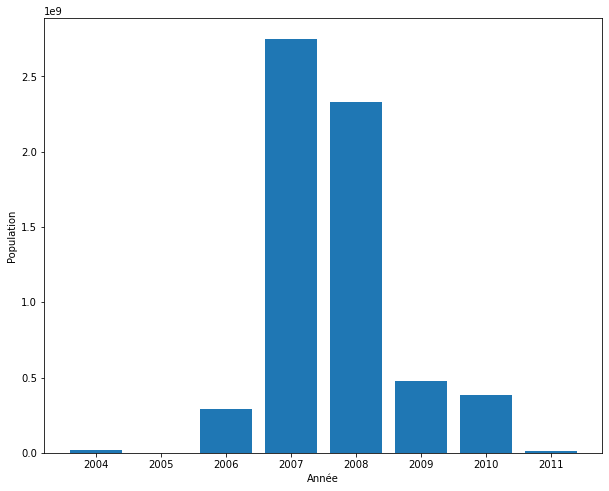

In [41]:
#Visualisation
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(population_mondiale['year'], population_mondiale['population'])
plt.xlabel('Année')
plt.ylabel('Population')

plt.savefig('population.jpg')
plt.show()

Seules les années 2007 et 2008 sont représentatives

#### 3. Indice de Gini

In [42]:
gini = pd.read_csv(r"C:\Users\elodi\Downloads\indice_gini.csv", skiprows=4).reset_index()
gini.head()

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,0,Aruba,ABW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Afghanistan,AFG,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Angola,AGO,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN,NaN


In [43]:
#On sélectionne les années couvertes par l'analyse
gini_columns = []
for value in gini.columns:
    gini_columns.append(value)
    
gini_vars = [year for year in gini_columns if year in (['2004', '2006', '2007', '2008', '2009', '2010', '2011'])]

In [44]:
#Mise en forme du dataframe pour obtenir uniquement les indices de Gini disponibles sur les années ci-dessus
gini_melt = pd.melt(gini, id_vars =['Country Code', 'Country Name'], value_vars = gini_vars, var_name ='year', 
                    value_name ='gini')
gini_melt.rename(columns={'Country Code':'country_code', 'Country Name':'country'}, inplace=True)
gini_melt['gini'] = round(gini_melt['gini']/100, 2)
gini_melt.dropna(inplace=True)
gini_melt['year'] = gini_melt['year'].astype(int)
gini_melt

,country_code,country,year,gini
9,ARG,Argentina,2004,0.48
10,ARM,Armenia,2004,0.38
13,AUS,Australia,2004,0.33
14,AUT,Austria,2004,0.30
15,AZE,Azerbaijan,2004,0.27
...,...,...,...,...
1844,UKR,Ukraine,2011,0.25
1846,URY,Uruguay,2011,0.42
1847,USA,United States,2011,0.41
1857,XKX,Kosovo,2011,0.28


In [45]:
#Merge indici de Gini avec data
data = pd.merge(data, gini_melt, how='left', on=['country_code', 'country', 'year'])
data.head()

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297,3002678.0,0.3
1,ALB,Albania,2008,2,100,916.66235,7297,3002678.0,0.3
2,ALB,Albania,2008,3,100,1010.91600,7297,3002678.0,0.3
3,ALB,Albania,2008,4,100,1086.90780,7297,3002678.0,0.3
4,ALB,Albania,2008,5,100,1132.69970,7297,3002678.0,0.3


In [46]:
#Vérification valeurs manquantes
print(data.isnull().sum())

country_code       0
country            0
year               0
quantile           0
nb_quantiles       0
income             0
gdpppp             0
population         0
gini            3800
dtype: int64


In [47]:
#Liste des pays sans indice de Gini 
gini_0 = data[data['gini'].isnull()][['country_code','country', 'year']]
pays_gini = list(gini_0['country'].unique())
print(pays_gini)

['Azerbaijan', 'Central African', 'Canada', 'China', "Côte d'Ivoire", 'Egypt', 'Ghana', 'Guatemala', 'Croatia', 'India', 'Islamic Republic of Iran', 'Iraq', 'Kenya', 'Kyrgyzstan', 'Cambodia', 'Republic of Korea', 'Kosovo', "Lao People's Democratic Republic", 'Sri Lanka', 'Morocco', 'Republic of Moldova', 'The Former Yugoslav Republic of Macedonia', 'Mali', 'Montenegro', 'Malaysia', 'Nigeria', 'Pakistan', 'Russian Federation', 'Serbia', 'Slovakia', 'Swaziland', 'Syrian Arab Republic', 'Taiwan', 'United Republic Of Tanzania', 'Venezuela', 'Occupied Palestinian Territory', 'Yemen', 'The Democratic Republic Of The Congo']


In [48]:
print(len(pays_gini))

38


In [49]:
gini_0 = data[data.isna().any(axis=1)].drop_duplicates(subset=['country_code', 'quantile', 'year'])
gini_0

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
400,AZE,Azerbaijan,2008,1,100,397.53983,8101,8821873.0,NaN
401,AZE,Azerbaijan,2008,2,100,597.77320,8101,8821873.0,NaN
402,AZE,Azerbaijan,2008,3,100,705.47003,8101,8821873.0,NaN
403,AZE,Azerbaijan,2008,4,100,785.52610,8101,8821873.0,NaN
404,AZE,Azerbaijan,2008,5,100,841.75244,8101,8821873.0,NaN
...,...,...,...,...,...,...,...,...,...
11594,COD,The Democratic Republic Of The Congo,2008,96,100,810.62330,"303,19305",60411195.0,NaN
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,"303,19305",60411195.0,NaN
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,"303,19305",60411195.0,NaN
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,"303,19305",60411195.0,NaN


In [50]:
list_gini = []
for code in gini_0['country_code'] : 
    dep = gini_0[gini_0['country_code'] == code]['income'].values
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()

    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
    S = 0.5 - AUC 
    gini = round(2*S, 2)
    list_gini.append(gini)

In [51]:
#Intégration des indices de Gini dans "country_gini" issu de "gini_0"
country_gini = gini_0.copy()
country_gini.loc[:,'gini'] = list_gini
country_gini

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
400,AZE,Azerbaijan,2008,1,100,397.53983,8101,8821873.0,0.31
401,AZE,Azerbaijan,2008,2,100,597.77320,8101,8821873.0,0.31
402,AZE,Azerbaijan,2008,3,100,705.47003,8101,8821873.0,0.31
403,AZE,Azerbaijan,2008,4,100,785.52610,8101,8821873.0,0.31
404,AZE,Azerbaijan,2008,5,100,841.75244,8101,8821873.0,0.31
...,...,...,...,...,...,...,...,...,...
11594,COD,The Democratic Republic Of The Congo,2008,96,100,810.62330,"303,19305",60411195.0,0.44
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,"303,19305",60411195.0,0.44
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,"303,19305",60411195.0,0.44
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,"303,19305",60411195.0,0.44


In [52]:
#Intégration des valeurs manquantes dans "data"
for code in list(country_gini['country_code'].unique()) :
    data.loc[data['country_code'] == code,'gini'] = (country_gini.loc[country_gini['country_code'] == code,'gini'])
    
#Visualisation rapide des données
data

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297,3002678.0,0.30
1,ALB,Albania,2008,2,100,916.66235,7297,3002678.0,0.30
2,ALB,Albania,2008,3,100,1010.91600,7297,3002678.0,0.30
3,ALB,Albania,2008,4,100,1086.90780,7297,3002678.0,0.30
4,ALB,Albania,2008,5,100,1132.69970,7297,3002678.0,0.30
...,...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,"303,19305",60411195.0,0.44
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,"303,19305",60411195.0,0.44
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,"303,19305",60411195.0,0.44
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,"303,19305",60411195.0,0.44


In [53]:
#Vérification des éventuelles valeurs manquantes
display(data.isna().any())

country_code    False
country         False
year            False
quantile        False
nb_quantiles    False
income          False
gdpppp          False
population      False
gini            False
dtype: bool

In [54]:
data.to_csv("data.csv", index = False)